# Altering Images so that they meet the requirements from the SHAPR model (GAN)

The Images are provided by the Swiss Institue of Translational and Entrepreneurial Medicine (SITEM) in Bern, Switzerland.


The model requires the images to be in shape of 64x64 pixels. The images in the folder "Images_for_prediction" have different shapes according to the size of the red blood cell. 

This script aims to alter these images and save them as 64x64px images in the folder "image" which can then later be used to perform the predictions on them. 

### Trying to change the size of the image without altering the aspect ratio of the RBC. (Without streching the RBC) 
### In addition a gray background canvas is added so that it meets the 64x64 pixel size

### Try it on a single image

#### Import dependencies

In [1]:
from PIL import Image

#### Load Images

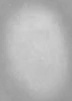

In [2]:
original_image = Image.open("Images_for_prediction/cell_frame004148_x0126_y0201_red.jpg")
original_image

#### Calculate aspect ratio

In [3]:
desired_width, desired_height = 64, 64
desired_aspect_ratio = desired_width / desired_height

#### Determine the image-scale-factor for resizing while preserving the aspect ratio:


In [4]:
current_width, current_height = original_image.size
current_aspect_ratio = current_width / current_height

if current_aspect_ratio > desired_aspect_ratio:
    # The original image is wider than the desired aspect ratio, so the width will be the limiting factor.
    scale_factor = desired_width / current_width
else:
    # The original image is taller than the desired aspect ratio, so the height will be the limiting factor.
    scale_factor = desired_height / current_height

scale_factor 

0.6336633663366337

#### Calculate the new size based on the scale factor

In [5]:
new_size = (int(current_width * scale_factor), int(current_height * scale_factor))
new_size

(45, 64)

#### Resize the image while preserving the aspect ratio

C:\Users\Domin\AppData\Local\Temp\ipykernel_27424\3999035377.py:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = original_image.resize(new_size, Image.ANTIALIAS)


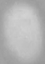

In [6]:
resized_image = original_image.resize(new_size, Image.ANTIALIAS)
resized_image


Create a  square canvas with a gray background:


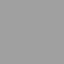

In [8]:
# get color value for the gray background from the first pixel at the top left corner which is always the background value
import cv2
img = cv2.imread("Images_for_prediction/cell_frame004148_x0126_y0201_red.jpg",2)
background_value = img[0][0]
background_value = int(background_value)


canvas = Image.new("L", (desired_width, desired_height), background_value) 
canvas


#### Paste the resized image onto the center of the canvas

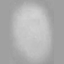

In [9]:
paste_position = ((desired_width - new_size[0]) // 2, (desired_height - new_size[1]) // 2)
canvas.paste(resized_image, paste_position)
canvas


#### Save the resulting image 


In [10]:
canvas.save("Created_Images/resized_RBC.png")  



## Apply above code to all the images in the folder "Images_for_prediction" and save to "image" as Tif file

In [12]:
import os
from PIL import Image

# Set the path to the folder containing the images
folder_path = "Images_for_prediction"  
result_path = "image" 

# Set the desired dimensions for resizing
desired_width, desired_height = 64, 64
desired_aspect_ratio = desired_width / desired_height

# Loop over all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Load the original image
        file_path = os.path.join(folder_path, filename)
        original_image = Image.open(file_path)

        # get pixel values of all corners
        top_left_color = original_image.getpixel((0, 0))
        top_right_color = original_image.getpixel((original_image.width - 1, 0))
        bottom_left_color = original_image.getpixel((0, original_image.height - 1))
        bottom_right_color = original_image.getpixel((original_image.width - 1, original_image.height - 1))

        # Find the lowest pixelvalue of the four corner for the background color of the canvas
        background_color = (min(top_left_color, top_right_color, bottom_left_color, bottom_right_color))
       
        # Perform the resizing and the canvas creation
        current_width, current_height = original_image.size
        current_aspect_ratio = current_width / current_height

        if current_aspect_ratio > desired_aspect_ratio:
            scale_factor = desired_width / current_width
        else:
            scale_factor = desired_height / current_height

        new_size = (int(current_width * scale_factor), int(current_height * scale_factor))

        resized_image = original_image.resize(new_size, Image.ANTIALIAS)
        resized_image = resized_image.convert("L") # grayscale

        canvas = Image.new("L", (desired_width, desired_height), background_color) 

        paste_position = ((desired_width - new_size[0]) // 2, (desired_height - new_size[1]) // 2)
        canvas.paste(resized_image, paste_position)
       

        # Save the resulting image to the new folder
        new_file_path = os.path.join(result_path, filename)
        canvas.save(new_file_path)

        print(f"Resized image saved: {new_file_path}")


Resized image saved: image\cell_frame004148_x0126_y0201_red.jpg


C:\Users\Domin\AppData\Local\Temp\ipykernel_27424\3224825546.py:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = original_image.resize(new_size, Image.ANTIALIAS)


## Binary Thresholding so that the RBC is well segmented and the images can be saved to the "mask" folder

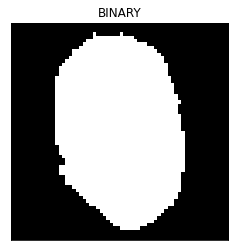

In [14]:
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
a= 175#defined as good result after testing on multiple images 
img = cv.imread('image/cell_frame004148_x0126_y0201_red.jpg', 2) #example image to test the code
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh = cv.threshold(img,a,255,cv.THRESH_BINARY)

title = 'BINARY'
cv.imwrite("Created_Images/thresholded_RBC.png", thresh)


plt.imshow(thresh,'gray',vmin=0,vmax=255)
plt.title(title)
plt.xticks([]),plt.yticks([])
plt.show()

### Adapted code so that it can be applied to all the images in the folder "image"

In [15]:
import cv2 as cv
import os
from matplotlib import pyplot as plt

# Set the path to the folder containing the images
folder_path = "image" 
result_path = "mask"

# Set the threshold value
threshold_value = 175 #manually identified


# Loop over all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the original image
        file_path = os.path.join(folder_path, filename)
        img = cv.imread(file_path, 2)
        assert img is not None, f"{file_path} could not be read, check with os.path.exists()"

        # Apply thresholding
        ret, thresh = cv.threshold(img, threshold_value, 255, cv.THRESH_BINARY)

        # Save the thresholded image to the output folder
        output_file_path = os.path.join(result_path, f"{filename}")
        
        cv.imwrite(output_file_path, thresh)


With this script and the images in the folder "image" and "mask" it is now possible to predict the shape of the RBC. For this the notebook "BTHE_applying_SHAPR" is created